In [3]:
from sympy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy.plotting import plot3d
from sympy.solvers.ode.systems import dsolve_system
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import * # Contains norm pdf and cdf
from sympy.core.sympify import sympify

from sympy.utilities.lambdify import lambdify

## Analytical Model for Put Price Option on $T_1$ Bond

In [37]:
T, T0, T1, s, theta, k, sigma, r0, t = symbols('T T_0 T_1 s theta kappa sigma r_0 t', positive = True)

In [38]:
params = [(k, 1.52102858), (theta, 0.0571262578729326), (sigma, 0.02934939), (r0, 0.06), (T0, 1), (T, 2)]
delta = (T-T0).subs(params)

In [69]:
strike = 0.0475
forward = exp(-k*T)*(r0-theta)+theta-sigma**2/(2*k**2)*(1-exp(-k*T))**2
P0 = exp(-integrate(forward, (T, 0, T0)))
P1 = exp(-integrate(forward, (T, 0, T)))
K = 1/(1+delta*strike)

# Volatilities
v0 = -integrate(sigma*exp(-k*(T0-t)), (t, t, T0))
v1 = -integrate(sigma*exp(-k*(T-t)), (t, t, T))
v01 = integrate((v0-v1)**2, (t, 0, T0))

In [70]:
d1 = simplify((ln(P1/(K*P0)) + 1/2*v01)/sqrt(v01))
d2 = simplify((ln(P1/(K*P0)) - 1/2*v01)/sqrt(v01))

In [71]:
put = simplify(K*P0*norm.cdf(float(-d2.subs(params)))-P1*norm.cdf(float(-d1.subs(params))))

In [72]:
put.subs(params)*100000

1010.68645814535

## Monty-Carlo Simulation - Put Price Option on $T_1$ Bond

In [122]:
# encoded vasicek in bond formula
def Bond(r0 = 0.06, kappa = 1.52102858, theta = 5.71262578729326/100, Volatility = 0.02934939, Time = 2, Maturity = 1,
         Steps = 252, Paths = 5000, n_plots = 25, strike = 0.0475):

    sigma = Volatility
    Np = Paths # number of paths
    Nt = Steps+1 # number of samples
    dt = Time/Steps
    z = np.random.normal(loc=0, scale=1, size = (Nt, Np)) # Continous standardized RV z = [0,1]
    
    r = np.zeros(shape = (Nt, Np))
    r[0] = r0
    
    for i in range(1, Nt):
        r[i] = r[i-1] + kappa*(theta-r[i-1])*dt + sigma*z[i]*np.sqrt(dt)
    
    def A(t = 0, T = Time):
        return (T - t)*(2*kappa**2*theta - sigma**2)/(2*kappa**2) + sigma**2*np.exp(-2*kappa*(T - t))/(4*kappa**3) + (kappa**2*theta - sigma**2)*np.exp(-kappa*(T - t))/kappa**3 - (4*kappa**2*theta - 3*sigma**2)/(4*kappa**3)
    def B(t = 0, T = Time):
        return 1/kappa - np.exp(-kappa*(T - t))/kappa
    def P(t = 0, T = Time):
        return np.exp(-A(t, T)[:, None] - B(t, T)[:, None]*r)

    discount = P(np.arange(0, Time+0.001, Time/Steps), Time)
    LIBOR = 1/(Time-np.arange(0, Time+0.001, Time/Steps)[:-1,None])*(1/discount[:-1]-1)
    
    fig, ax = plt.subplots(figsize = [12, 8]);
    ax.plot(discount[:,:n_plots])
    plt.ylabel('$Price(\$)$', fontsize = 16)
    plt.xlabel('Time $t$ in years', fontsize = 16)
    ax.spines[["right", "top"]].set_visible(False)
    times = np.arange(0, Time+1).astype(int)
    x = (Steps*times/Time).astype(int)
    plt.xticks(x, times, size = 14)
    plt.yticks(size = 14)
    ax.tick_params(direction = 'in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=.1)

    ax.plot(1/(1+(Time-np.arange(0, Time+0.001, Time/Steps))*strike), linestyle='dashed', c = 'b', lw = '2', label = 'Strike={:.2f}%'.format(strike*100))
    ax.axvline(x=np.floor(len(r)*Maturity/Time).astype(int), color='r', linestyle='--', label = 'Option Maturity')
    plt.legend(title = 'Legend', title_fontsize = 14, fontsize = 14);
    
    K = 1/(1+(Time-Maturity)*strike)
    payoff = np.fmax(K - discount[np.floor(len(r)*Maturity/Time).astype(int)], 0)
    d = (1/((1+r[:np.floor(len(r)*Maturity/Time).astype(int)+1])**dt)).cumprod(axis=0)[-1]
    
    price = payoff*d
    return discount, LIBOR, price


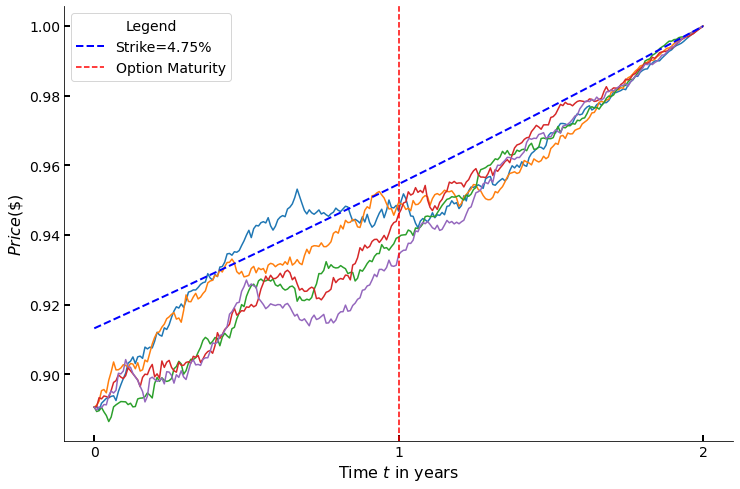

In [124]:
np.random.seed(42)
discount, LIBOR, price = Bond(r0 = 0.06, kappa = 1.52102858, theta = 5.71262578729326/100, Volatility = 0.02934939, Maturity = 1, Time = 2,
         Steps = 252, Paths = int(1e6), n_plots = 5, strike = 0.0475)